# Study transfer learning
Since baby env aims to build model for "real" world, here we study the impact of parameters on transfer learning.

In [1]:
import gym
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import baby.envs
from baby.envs.baby_env import default_conf

In [2]:
# Create env
env = gym.make('baby-v0')

In [3]:
env.conf

{'seed': 0,
 'n_frame': 20,
 'n-xaxis': 21,
 'n-yaxis': 9,
 'max_episode_iteration': 1000,
 'alpha_ground_truth': 0.8,
 'validation_threshold': 0.8,
 'sigma_prediction': 0.5,
 'gamma_gaussian_value': 0.2,
 'sigma_gaussian_value': 0.8,
 'reward': {'timestep': 0, 'validation': 1}}

In [39]:
env.conf['sigma_prediction'] = 1.0
env.conf['gamma_gaussian_value'] = 0.5
env.conf['sigma_gaussian_value'] = 2.0

In [40]:
# We want to compute forecast error depending on (t, ground_truth_values)
class_step = 0.1
ground_truth_classes = np.arange(start=0.0, stop=1.0, step=0.1)

Resetting env at n=0
Resetting env at n=50
Resetting env at n=100
Resetting env at n=150


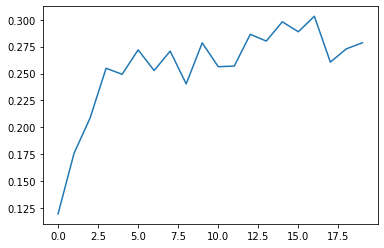

In [41]:
# Create container of absolute error as function of value_class and time
error_t = np.zeros(env.conf['n_frame'])
error_classes_t = {}
count_classes_t = {}

# Initialize classes results
for c in ground_truth_classes:
    error_classes_t[f"v_{c}_{c+class_step}"] = np.zeros(env.conf['n_frame'])
    count_classes_t[f"v_{c}_{c+class_step}"] =  np.zeros(env.conf['n_frame'])

    
obs = env.reset()
t = 0
n_iteration = 200
freq_reset = 50

for n in range(n_iteration):

    # Look out on first step
    for i in range(env.conf['n_frame']):
        ct = i+t
        error = np.mean(np.abs(obs[:, :, i] - env.ground_truth[:, :, ct]))
        error_t[i] = error


        for x in range(env.conf['n-xaxis']):
            for y in range(env.conf['n-yaxis']):
                abs_e = np.abs(obs[y, x, i] - env.ground_truth[y, x, ct])
                idx_class = np.where(obs[y, x, i] >= ground_truth_classes)[0][-1]

                start_v = ground_truth_classes[idx_class]
                end_v = start_v + class_step

                class_str = f"v_{start_v}_{end_v}"
                error_classes_t[class_str][i] += abs_e
                count_classes_t[class_str][i] += 1
       
    # Fake action
    obs, rew, done, info = env.step(0)
    t += 1
    
    if n % freq_reset == 0:
        print(f"Resetting env at n={n}")
        obs = env.reset()
        t=0
    
plt.plot(error_t)
plt.show()

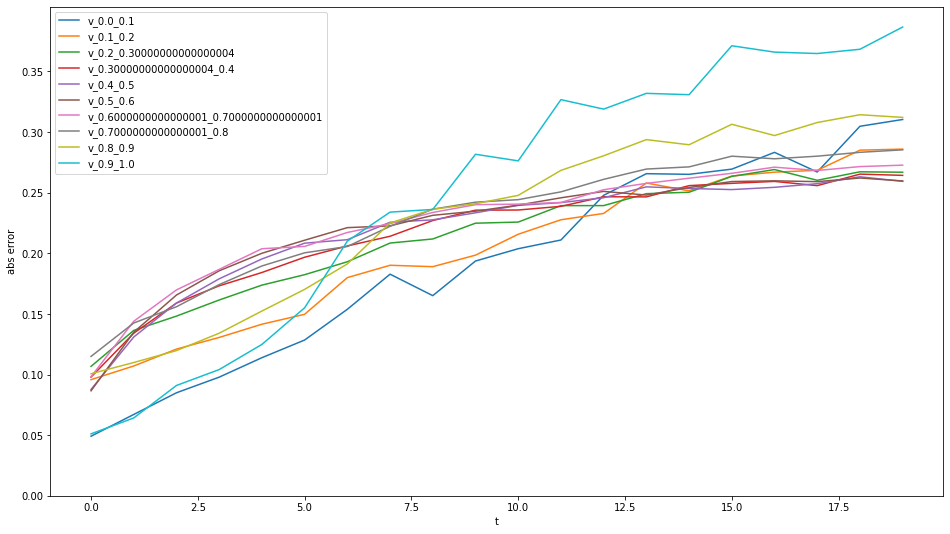

In [42]:
# Print mean  error classes

plt.figure(figsize=(16, 9))
    
for c in error_classes_t.keys():
    d = error_classes_t[c]/count_classes_t[c]
    plt.plot(d, label=c)
    
plt.xlabel('t')
plt.ylabel('abs error')

plt.yticks(np.arange(0.0, 0.4, 0.05))
plt.legend()
plt.show()

In [43]:
# Check first class count
count_classes_t[list(count_classes_t.keys())[0]]

array([1066.,  671.,  576.,  644.,  606.,  712.,  737.,  723.,  782.,
        794., 1036., 1190., 1197., 1289., 1348., 1419., 1581., 1657.,
       1640., 1975.])